In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import re
import nltk

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [13]:
train_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

In [14]:
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [16]:
train_df.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [18]:
# checking the size of training data 
train_df.shape

(159571, 8)

In [17]:
# check missing values in numeric columns
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


There are no missing numeric values. As the mean values are very small (some way below 0.05), there would be many not labelled as positive in the six categories. From this I guess that there would be many comments which are not labelled in any of the six categories. Let's take a look.

In [19]:
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['obscene']!=1) & 
                            (train_df['threat']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1)]

print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_df)*100)

Percentage of unlabelled comments is  89.83211235124176


around 90% of data is non-toxic data 


In [20]:
# check for any 'null' comment
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [22]:
# let's see the total rows in train, test data and the numbers for the various categories
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())


Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


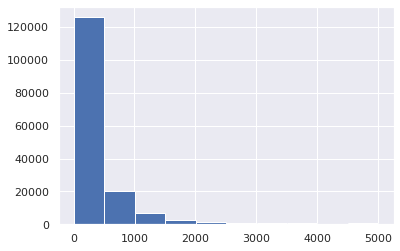

In [23]:
# Let's look at the character length for the rows in the training data and record these
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))
# look at the histogram plot for text length
sns.set()
train_df['char_length'].hist()
plt.show()

Most of the text length are within 500 characters, with some up to 5,000 characters long.

Next, let's examine the correlations among the target variables

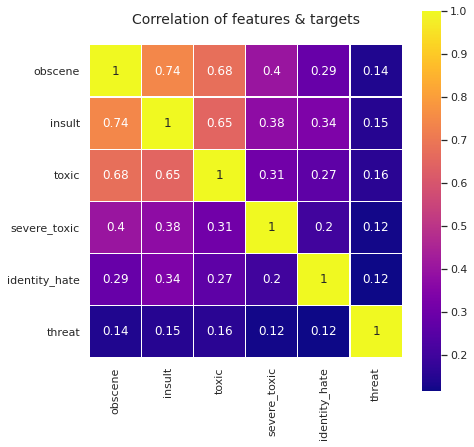

In [24]:
data = train_df[cols_target]
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.

In [ ]:
# Clean up the comment text 

In [26]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [27]:
# clean the comment_text in train_df [Thanks to Pulkit Jha for the useful pointer.]
train_df['comment_text'] = train_df['comment_text'].map(lambda com : clean_text(com))

In [28]:
# clean the comment_text in test_df [Thanks, Pulkit Jha.]
test_df['comment_text'] = test_df['comment_text'].map(lambda com : clean_text(com))

In [29]:
#Define X from entire train & test data for use in tokenization by Vectorizer
train_df = train_df.drop('char_length',axis=1)
X = train_df.comment_text
test_X = test_df.comment_text
print(X.shape, test_X.shape)

(159571,) (153164,)


#  vectorize the Data 

In [31]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(max_features=5000, stop_words='english')

In [32]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
# examine the document-term matrix created from X_train
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3178715 stored elements in Compressed Sparse Row format>

In [33]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(test_X)
# examine the document-term matrix from X_test
test_X_dtm

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2618947 stored elements in Compressed Sparse Row format>